# Logistic Regression

逻辑回归模型是一种常用的分类模型，它通过sigmoid或者softmax函数，将函数值映射到(0, 1)区间内，从而实现对样本的分类。在这个小作业中，你需要实现：
1. 二分类和多分类两种逻辑回归模型
2. 分别含有 L1 和 L2 两种正则项的损失函数，并计算对应的梯度
3. 权重参数W的更新
4. 比较不同的学习率对损失函数和分类器性能的影响
5. 比较不同的正则项参数对于分类器性能的影响
   
**本次小作业截止时间：2022/4/4 23:59, 请在canvas系统中及时提交。**

# 一、二分类逻辑回归：
### 1.1数据集介绍
这个任务中使用的数据集是手写数字集MNIST，它有60000个训练样本和10000个测试样本，共10个类别。在二分类任务上，我们对MNIST数据集进行了一个采样，抽取了数据集中的‘5’和‘3’对应的样本作为二分类的正负样本，共得到11552个训练样本，1902个测试样本，其中正负样本数量均相同。为了让大家对于这个数据集有一个更直观的认识，我们从正负样本中各抽取了8个样例进行了可视化。

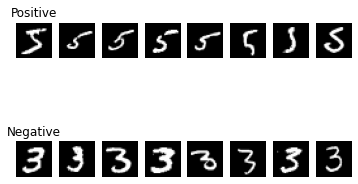

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_data1(path):
    # load all MNIST data
    fd = open(os.path.join(path, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    train_X_all = loaded[16:].reshape((60000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    train_Y_all = loaded[8:].reshape(60000).astype(np.float)
    fd = open(os.path.join(path, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    test_X_all = loaded[16:].reshape((10000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    test_Y_all = loaded[8:].reshape(10000).astype(np.float)

    #subsample data
    train_3_mask, train_5_mask = (train_Y_all == 3), (train_Y_all == 5) 
    test_3_mask, test_5_mask = (test_Y_all == 3), (test_Y_all == 5)
    train_Y_all[train_5_mask] = 1
    train_Y_all[train_3_mask] = 0
    test_Y_all[test_5_mask] = 1
    test_Y_all[test_3_mask] = 0
    train_mask = np.logical_or(train_5_mask, train_3_mask)
    test_mask = np.logical_or(test_5_mask, test_3_mask)
    train_X = train_X_all[train_mask]
    train_Y = train_Y_all[train_mask]
    test_X = test_X_all[test_mask]
    test_Y = test_Y_all[test_mask]

    #visualize data
    sample_num = 8
    for i in range(sample_num):
        plt_idx = i + 1
        plt.subplot(2, sample_num, plt_idx)
        plt.imshow(train_X_all[train_5_mask][i].reshape((28, 28)), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title('Positive')

    for i in range(sample_num):
        plt_idx = sample_num + i + 1
        plt.subplot(2, sample_num, plt_idx)
        plt.imshow(train_X_all[train_3_mask][i].reshape((28, 28)), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title('Negative')
    plt.show()
    # reshaple into rows and normalize
    train_X = train_X.reshape((train_X.shape[0], -1))
    test_X = test_X.reshape((test_X.shape[0], -1)) # reshape(shape[0],-1): reshape (a,b,c,d) into (a,b*c*d)
    mean_image = np.mean(train_X, axis=0) # axis=0: calculate mean of every column
    train_X = train_X - mean_image
    test_X = test_X - mean_image

    # add a bias column into X
    train_X = np.hstack([train_X, np.ones((train_X.shape[0], 1))])
    test_X = np.hstack([test_X, np.ones((test_X.shape[0], 1))]) # np.ones/zeros/eyes([row, col])
    return train_X, train_Y, test_X, test_Y


X_train, Y_train, X_test, Y_test = load_data1('./dataset/Assignment1/')

In [2]:
print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X_train shape is (11552, 785)
Y_train shape is (11552,)
X_test shape is (1902, 785)
Y_test shape is (1902,)


### 1.2逻辑回归模型
在这部分我们将会使用梯度下降算法训练逻辑回归模型。我们将会进行固定次数的迭代，在每个迭代过程中我们将计算数据样本的损失大小，以及对每个权重参数的梯度求导，并在此基础上进行梯度下降。算法的核心公式（此处包括损失函数和梯度下降，未包含正则项，在后面的实际要求中需要实现正则项）如下：

$$
L(f(x), y) = -y\log{f(x)}-(1-y)\log(1-f(x)), f(x) = \frac{e^{wx + b}}{1 + e^{wx + b}}
$$
$$
\begin{aligned}
\forall k, \frac{\partial}{\partial w_k} L(w,b) = \frac{1}{N}\sum_{i=1}^N (f(x^{(i)}) - y^{(i)}) x^{(i)}_k
\end{aligned}
$$

$$
\begin{aligned}
\frac{\partial}{\partial b} L(w,b)= \frac{1}{N}\sum_{i=1}^N (f(x^{(i)}) - y^{(i)})
\end{aligned}
$$


在这一部分中你需要完成以下内容：
1. train函数中权重$W$的更新
2. L1和L2两种正则化的损失函数及对应梯度的计算
3. predict函数中的预测类别的计算

#### Question0:
在下面利用线性模型进行逻辑回归的代码实现中，我们可以只需要权重矩阵 $W$ 而并不需要偏置项 $b$ ，为什么？（提示：之前的数据预处理过程中，除了将 $28 \times 28$ 的片“拍扁”并normalize以外，我们还做了哪步处理？）

#### Answer:

In [37]:

class LinearRegression1(object):
    def __init__(self):
        self.W = None
    
    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, reg_type='L2', show_detail=True, num_iters=2000,
          batch_size=128):
        num_train, feat_dim = X.shape
        self.W = 0.001 * np.random.randn(feat_dim)
        loss_history = []
        if show_detail:
            print("train begin")
        for i in range(num_iters):
            batch_indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            if reg_type == 'L1':
                loss, grad = self.l1_loss(X_batch, Y_batch, reg)
            else:
                loss, grad = self.l2_loss(X_batch, Y_batch, reg)
            loss_history.append(loss)
            
            if learning_rate < 0:
                learning_rate = learning_rate*((2000-i)/4000+0.5)
            ########################################
            # TODO: Update W
            self.W = self.W - learning_rate*grad

            ########################################
            if show_detail and i % 100 == 0:
                print("In iteration {}/{} , the loss is {}".format(i, num_iters, loss))
        return loss_history
    
    def Sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def func_f(self, X):
        return 1-self.Sigmoid(-np.dot(X,self.W))

    def calc(self, X, Y):
        func = self.func_f(X)
        loss = np.sum(-Y*np.log(func)-(1-Y)*np.log(1-func))
        grad = (np.dot((func-Y).reshape(1,-1), X)).T
        grad = np.array(grad).flatten()
        return loss / X.shape[0], grad / X.shape[0]

    def l1_loss(self, X, Y, reg):
        loss = 0
        grad = None
    
        ########################################
        # TODO: Calculate the loss and gradient
        
        loss, grad = self.calc(X, Y)
        grad = grad + reg*np.sign(self.W)
        loss = loss + reg*np.linalg.norm(self.W,1)
        ########################################
        
        return loss, grad
    
    def l2_loss(self, X, Y, reg):
        loss = 0
        grad = None

        ########################################
        # TODO: Calculate the loss and gradient
        
        loss, grad = self.calc(X, Y)
        grad = grad + 2*reg*self.W
        loss = loss + reg*np.linalg.norm(self.W,2)
        ########################################

        return loss, grad
    
    def predict(self, X, threshold=0.5):
        Y_pred = None
        
        ########################################
        # TODO: Predict the label of X with threshold
        # Hint: You may use func_f
        Y_pred = []
        for i in range (X.shape[0]):
            pred = self.func_f(X[i])
            if pred > threshold: 
                Y_pred.append(1)
            else :
                Y_pred.append(0)
         
        ########################################
        
        return Y_pred

### 1.3 训练模型实例
在这一部分，你不需要完成任何代码，你可以通过这一部分验证你上面实现的LogisticRegression1的代码是否实现正确。

train begin
In iteration 0/2000 , the loss is 1.0196449514593464
In iteration 100/2000 , the loss is 0.20692757407428977
In iteration 200/2000 , the loss is 0.18602281672852158
In iteration 300/2000 , the loss is 0.1737186781844082
In iteration 400/2000 , the loss is 0.1565396559854932
In iteration 500/2000 , the loss is 0.21571872565193892
In iteration 600/2000 , the loss is 0.1306976788435353
In iteration 700/2000 , the loss is 0.09211380799119706
In iteration 800/2000 , the loss is 0.1584405864771909
In iteration 900/2000 , the loss is 0.08745335592641416
In iteration 1000/2000 , the loss is 0.101084049424521
In iteration 1100/2000 , the loss is 0.10995033333638017
In iteration 1200/2000 , the loss is 0.1079586059314306
In iteration 1300/2000 , the loss is 0.2137317137993687
In iteration 1400/2000 , the loss is 0.09900951746311976
In iteration 1500/2000 , the loss is 0.12332621730431569
In iteration 1600/2000 , the loss is 0.12778166290684814
In iteration 1700/2000 , the loss is 0.1

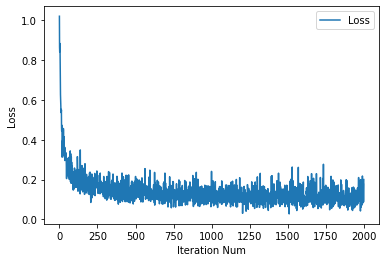

In [42]:
lr_param = 1.5e-6
reg_param = 0.01

model = LinearRegression1()
loss_history = model.train(X_train, Y_train, lr_param, reg_param, 'L2', True)
pred = model.predict(X_test)
acc = np.mean(pred == Y_test)
print("The Accuracy is {}\n".format(acc))
x = range(len(loss_history))
plt.plot(x, loss_history, label='Loss')
plt.legend()
plt.xlabel('Iteration Num')
plt.ylabel('Loss')
plt.show()
W = model.W

### 1.4 学习率和Loss函数、模型性能的关系
因为学习率和正则化参数都是超参数，在一般的训练过程中，我们没办法直接优化，所以我们一般会将训练集细分成训练集和验证集，然后通过模型在验证集上的表现选择一个最优的超参数，再将它对应的最优的模型应用到测试集中。
在这一部分你需要完成以下内容：
1. 在L1、L2两种正则化下尝试多种不同的学习率
2. 储存学习率对应的损失函数值到L1_loss和L2_loss中（我们对损失函数值进行了20步平均化处理）。
3. 储存学习率对应的**在验证集上**的正确率到L1_lr_val_acc和L2_lr_val_acc中

#### 注意：
你可以参考1.3的代码进行训练参数的设置。

因为已有代码中L1_loss，L1_lr_val_acc都是数组，在可视化的过程中我们需要学习率和它们相对应，比如learning_rates[0]对应的loss和validation accuracy应该储存在数组index为0的位置

#### 拓展：
在这个部分中采取的损失函数都是定值，如果你有时间的话，可以尝试根据迭代轮数改变学习率，并比较不变的学习率和变化的学习率对于模型性能的影响。

train begin
In iteration 0/2000 , the loss is 0.8315894528400869
In iteration 100/2000 , the loss is 0.7601527259303819
In iteration 200/2000 , the loss is 0.9167770851039833
In iteration 300/2000 , the loss is 0.8101033230832696
In iteration 400/2000 , the loss is 0.9139102536419058
In iteration 500/2000 , the loss is 0.7679860666760929
In iteration 600/2000 , the loss is 0.9298171728654279
In iteration 700/2000 , the loss is 0.7842507306588558
In iteration 800/2000 , the loss is 0.7544588812266381
In iteration 900/2000 , the loss is 0.8476320720000657
In iteration 1000/2000 , the loss is 0.7892440352678091
In iteration 1100/2000 , the loss is 0.8314468685387163
In iteration 1200/2000 , the loss is 0.8241587521027606
In iteration 1300/2000 , the loss is 0.7847040331735463
In iteration 1400/2000 , the loss is 0.7787264662656092
In iteration 1500/2000 , the loss is 0.8282469194407246
In iteration 1600/2000 , the loss is 0.7968883930101727
In iteration 1700/2000 , the loss is 0.750549322

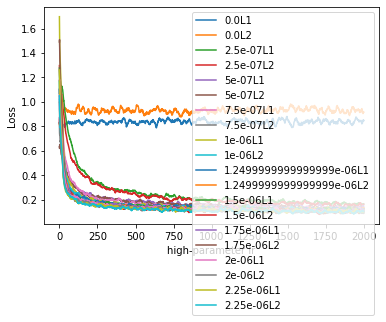

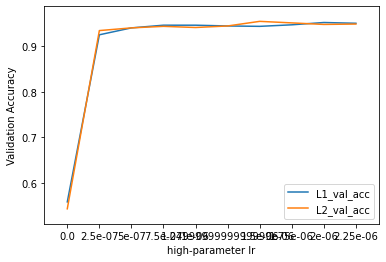

In [43]:
reg = 0.01
reg_types = ['L1', 'L2']
L1_loss = []
L2_loss = []
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
L1_lr_val_acc = []
L2_lr_val_acc = []

########################################
# TODO: train & test model with different learning rates
learning_rates = []
for i in range(10):
    learning_rates.append((2.5e-7)*i)

for i in range(10):
    model = LinearRegression1()
    loss_history = model.train(X_train, Y_train, learning_rates[i], reg, 'L1', True)
    pred = model.predict(X_val)
    acc = np.mean(pred == Y_val)
    L1_loss.append(loss_history)
    L1_lr_val_acc.append(acc)

for i in range(10):
    model = LinearRegression1()
    loss_history = model.train(X_train, Y_train, learning_rates[i], reg, 'L2', True)
    pred = model.predict(X_val)
    acc = np.mean(pred == Y_val)
    L2_loss.append(loss_history)
    L2_lr_val_acc.append(acc)
    
########################################
#visulize the relationship between lr and loss
for i, lr in enumerate(learning_rates):
    L1_loss_label = str(lr) + 'L1'
    L2_loss_label = str(lr) + 'L2'
    L1_loss_i = L1_loss[i]
    L2_loss_i = L2_loss[i]
    ave_L1_loss = np.zeros_like(L1_loss_i)
    ave_L2_loss = np.zeros_like(L2_loss_i)
    ave_step = 20
    for j in range(len(L1_loss_i)):
        if j < ave_step:
            ave_L1_loss[j] = np.mean(L1_loss_i[0: j + 1])
            ave_L2_loss[j] = np.mean(L2_loss_i[0: j + 1])
        else:
            ave_L1_loss[j] = np.mean(L1_loss_i[j - ave_step + 1: j + 1])    
            ave_L2_loss[j] = np.mean(L2_loss_i[j - ave_step + 1: j + 1])
    x = range(len(L1_loss_i))
    plt.plot(x, ave_L1_loss, label=L1_loss_label)
    plt.plot(x, ave_L2_loss, label=L2_loss_label)
    
plt.legend()
plt.xlabel('high-parameter lr')
plt.ylabel('Loss')
plt.show()

#visulize the relationship between lr and accuracy
x = range(len(learning_rates))
plt.plot(x, L1_lr_val_acc, label='L1_val_acc')
plt.plot(x, L2_lr_val_acc, label='L2_val_acc')
plt.xticks(x, learning_rates)
plt.margins(0.08)
plt.legend()
plt.xlabel('high-parameter lr')
plt.ylabel('Validation Accuracy')
plt.show()

#### Question1: 学习率和损失函数的变化、模型性能之间分别有什么关系？

#### Answer: 如图所示，在7.5e-7至2.5e-6的区间里，损失函数沿多项式拟合函数随学习率增大而递减。在2.5e-7至2.5e-6的区间里，模型性能随学习率增大而递增。

### 1.5 正则项与模型性能
在这一部分中，你需要完成以下内容：
1. 尝试多个正则化参数的值
2. 储存对应的在**验证集上**的正确率到L1_reg_val_acc和L2_reg_val_acc中
3. 通过验证集X_val和Y_val选择最优的正则化超参数，并储存最优正则化参数和对应模型

已有的代码会画出正则化参数和验证集上正确率的关系图，并计算最优的模型在测试集上的正确率。

#### 注意：
和上面学习率一样，L1_reg_val_acc的存储也需要和正则化参数值对应。

train begin
In iteration 0/2000 , the loss is 0.8879027226819449
In iteration 100/2000 , the loss is 0.20908034333915232
In iteration 200/2000 , the loss is 0.17237465224697607
In iteration 300/2000 , the loss is 0.11732714010089695
In iteration 400/2000 , the loss is 0.11802504313748548
In iteration 500/2000 , the loss is 0.1409371974847498
In iteration 600/2000 , the loss is 0.0809972775445539
In iteration 700/2000 , the loss is 0.0883853402668425
In iteration 800/2000 , the loss is 0.09571979113465134
In iteration 900/2000 , the loss is 0.06986144346162838
In iteration 1000/2000 , the loss is 0.10779514286033916
In iteration 1100/2000 , the loss is 0.11284875129679439
In iteration 1200/2000 , the loss is 0.09314768919042687
In iteration 1300/2000 , the loss is 0.0857658529808962
In iteration 1400/2000 , the loss is 0.11329631750215202
In iteration 1500/2000 , the loss is 0.16440898312694144
In iteration 1600/2000 , the loss is 0.07578762635390143
In iteration 1700/2000 , the loss is

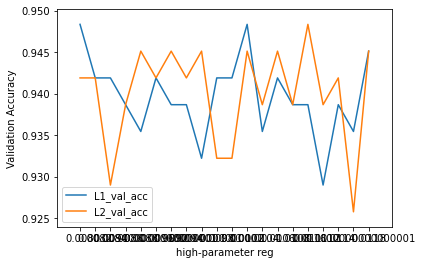

The Accuracy with L1 regularization parameter 0 is 0.9521556256572029

The Accuracy with L2 regularization parameter 0 is 0.9468980021030494



In [49]:
learning_rate = 1.5e-6
reg_types = ['L1', 'L2']
L1_reg_val_acc = []
L2_reg_val_acc = []
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
best_L1_model = None
best_L2_model = None
best_L1_reg = 0
best_L2_reg = 0
best_L1_acc = 0
best_L2_acc = 0

########################################
# TODO: train & test model with different regularization 
best_L1_acc = 0
best_L2_acc = 0
regs = []
for i in range(20):
    regs.append(0.008+0.0002*i)

for i in range(20):
    model = LinearRegression1()
    loss_history = model.train(X_train, Y_train, learning_rate, regs[i], 'L1', True)
    pred = model.predict(X_val)
    acc = np.mean(pred == Y_val)
    L1_reg_val_acc.append(acc)
    if best_L1_acc < acc:
        best_L1_acc = acc
        best_L1_model = model
for i in range(20):
    model = LinearRegression1()
    loss_history = model.train(X_train, Y_train, learning_rate, regs[i], 'L2', True)
    pred = model.predict(X_val)
    acc = np.mean(pred == Y_val)
    L2_reg_val_acc.append(acc)
    if best_L2_acc < acc:
        best_L2_acc = acc
        best_L2_model = model
########################################

#visulize the relation of regularization parameter and validation accuracy
x = range(len(regs))
plt.plot(x, L1_reg_val_acc, label='L1_val_acc')
plt.plot(x, L2_reg_val_acc, label='L2_val_acc')
plt.xticks(x, regs)
plt.margins(0.08)
plt.legend()
plt.xlabel('high-parameter reg')
plt.ylabel('Validation Accuracy')
plt.show()

#Compute the performance of best model on the test set
L1_pred = best_L1_model.predict(X_test)
L1_acc = np.mean(L1_pred == Y_test)
print("The Accuracy with L1 regularization parameter {} is {}\n".format(best_L1_reg, L1_acc))
L2_pred = best_L2_model.predict(X_test)
L2_acc = np.mean(L2_pred == Y_test)
print("The Accuracy with L2 regularization parameter {} is {}\n".format(best_L2_reg, L2_acc))

## 二、多分类逻辑回归


### 2.1 加载数据集

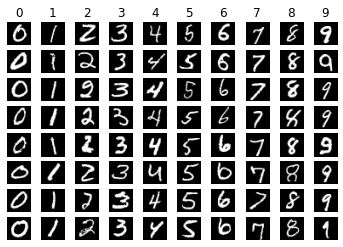

In [50]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_data2(path):
    # load all MNIST data
    fd = open(os.path.join(path, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    train_X = loaded[16:].reshape((60000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    train_Y = loaded[8:].reshape(60000).astype(np.float)
    fd = open(os.path.join(path, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    test_X = loaded[16:].reshape((10000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    test_Y = loaded[8:].reshape(10000).astype(np.float)

    #visualize data
    sample_num = 8
    num_classes = 10
    for y in range(num_classes):
        idxs = np.flatnonzero(train_Y == y)
        idxs = np.random.choice(idxs, sample_num, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(sample_num, num_classes, plt_idx)
            plt.imshow(train_X[idx, :, :, :].reshape((28,28)),cmap=plt.cm.gray)
            plt.axis('off')
            if i == 0:
                plt.title(y)
    plt.show()

    # reshaple into rows and normaliza
    train_X = train_X.reshape((train_X.shape[0], -1))
    test_X = test_X.reshape((test_X.shape[0], -1))
    mean_image = np.mean(train_X, axis=0)
    train_X = train_X - mean_image
    test_X = test_X - mean_image

    # add a bias columu into X
    train_X = np.hstack([train_X, np.ones((train_X.shape[0], 1))])
    test_X = np.hstack([test_X, np.ones((test_X.shape[0], 1))])
    train_Y = train_Y.astype(np.int32)
    test_Y = test_Y.astype(np.int32)
    return train_X, train_Y, test_X, test_Y


X_train, Y_train, X_test, Y_test = load_data2('./dataset/Assignment1/')

In [51]:
print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X_train shape is (60000, 785)
Y_train shape is (60000,)
X_test shape is (10000, 785)
Y_test shape is (10000,)


### 2.2逻辑回归模型
在这一部分中你需要完成与二分类逻辑回归相同的任务。

In [54]:
 from scipy.special import softmax

In [58]:
class LinearRegression2(object):
    def __init__(self):
        self.W = None
    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, reg_type='L2', show_detail=True, num_iters=2000,
              batch_size=128):
        num_train, feat_dim = X.shape
        num_classes = 10
        self.W = 0.001 * np.random.randn(feat_dim, num_classes)
        loss_history = []
        if show_detail:
            print("train begin")
        for i in range(num_iters):
            batch_indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            if reg_type == 'L1':
                loss, grad = self.l1_loss(X_batch, Y_batch, reg)
            else:
                loss, grad = self.l2_loss(X_batch, Y_batch, reg)
            loss_history.append(loss)
            
            ########################################
            # TODO: update W
            self.W = self.W - learning_rate*grad
            
            ########################################
       
            if show_detail and i % 100 == 0:
                print("In iteration {}/{} , the loss is {}".format(i, num_iters, loss))
        return loss_history

    def calc(self, X, Y):
        num_train, feat_dim = X.shape
        class_dim = self.W.shape[1]
        loss = 0
        grad = np.zeros([class_dim, feat_dim])
        #soft = softmax(np.dot(X, self.W))
        for i in range(num_train):
            soft = softmax(np.dot(X[i], self.W))
            loss += -np.log(soft[Y[i]])
            for j in range(class_dim):
                prob = soft[j]
                if j == Y[i]:
                    prob -= 1
                grad[j] += X[i] * prob
        grad = grad.T
        return loss / X.shape[0], grad / X.shape[0]

    def l1_loss(self,X, Y, reg):
        loss = 0
        grad = None
    
        ########################################
        # TODO: Calculate the loss and gradient
        loss, grad = self.calc(X, Y)
        loss = loss + reg*np.linalg.norm(self.W, 1)
        grad = grad + reg*np.sign(self.W)
        
        ########################################
    
        return loss, grad
            
    
    def l2_loss(self, X, Y, reg):
        loss = 0
        grad = None
        
        ########################################
        # TODO: Calculate the loss and gradient
        loss, grad = self.calc(X, Y)
        loss = loss + reg*np.linalg.norm(self.W, 2)
        grad = grad + 2*reg*self.W

        ########################################
        
        return loss, grad

    def predict(self, X):
        Y_pred = None
        ########################################
        # TODO: Predict the label of X
        Y_pred = []
        for i in range (X.shape[0]):
            maxsoft, maxj = 0, -1        
            soft = softmax(np.dot(X[i], self.W))
            
            for j in range (len(soft)):
                if maxsoft < soft[j]:
                    maxsoft, maxj = soft[j], j
            Y_pred.append(maxj)
        ########################################
    
        return Y_pred
        
def divide(a, b):
    return a / b

### 2.3 训练模型样例
在这一部分，你不需要完成任何代码，你可以通过这一部分验证你上面实现的LogisticRegression2的代码是否实现正确。

train begin
In iteration 0/2000 , the loss is 3.7101506402982074
In iteration 100/2000 , the loss is 0.9709634265439643
In iteration 200/2000 , the loss is 0.7037969660268719
In iteration 300/2000 , the loss is 0.6057496572086315
In iteration 400/2000 , the loss is 0.6232513826638205
In iteration 500/2000 , the loss is 0.42597206288464784
In iteration 600/2000 , the loss is 0.49341216396544
In iteration 700/2000 , the loss is 0.5815016886054225
In iteration 800/2000 , the loss is 0.5512004286035705
In iteration 900/2000 , the loss is 0.43619001120164436
In iteration 1000/2000 , the loss is 0.5315176968392362
In iteration 1100/2000 , the loss is 0.44533689719964015
In iteration 1200/2000 , the loss is 0.3717939240232541
In iteration 1300/2000 , the loss is 0.47531392879650636
In iteration 1400/2000 , the loss is 0.39236946912073906
In iteration 1500/2000 , the loss is 0.5111058523090429
In iteration 1600/2000 , the loss is 0.3465911224450222
In iteration 1700/2000 , the loss is 0.387025

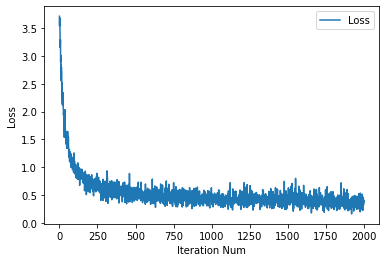

In [59]:
lr_param = 1e-6
reg_param = 0.01
model = LinearRegression2()
loss_history = model.train(X_train, Y_train, lr_param, reg_param, 'L2')
pred = model.predict(X_test)
acc = np.mean(pred == Y_test)
print("The Accuracy is {}\n".format(acc))
x = range(len(loss_history))
plt.plot(x, loss_history, label='Loss')
plt.legend()
plt.xlabel('Iteration Num')
plt.ylabel('Loss')
plt.show()

### 2.4 学习率与损失函数、模型性能的关系
因为学习率和正则化参数都是超参数，在一般的训练过程中，我们没办法直接优化，所以我们一般会将训练集细分成训练集和验证集，然后通过模型在验证集上的表现选择一个最优的超参数，再将它对应的最优的模型应用到测试集中。
在这一部分你需要完成以下内容：
1. 尝试多种不同的学习率
2. 储存学习率对应的损失函数值到L1_loss和L2_loss中（我们对损失函数值进行了20步平均化处理）。
3. 储存学习率对应的**在验证集上**的正确率到L1_lr_val_acc和L2_lr_val_acc中

#### 注意：
因为已有代码中L1_loss，L1_lr_val_acc都是数组，在可视化的过程中我们需要学习率和它们相对应，比如learning_rates[0]对应的loss和validation accuracy应该储存在数组index为0的位置

#### 拓展：
在这个部分中采取的损失函数都是定值，如果你有时间的话，可以尝试根据迭代轮数改变学习率，并比较不变的学习率和变化的学习率对于模型性能的影响。

train begin
In iteration 0/2000 , the loss is 3.0541079731984544
In iteration 100/2000 , the loss is 3.0920925843823737
In iteration 200/2000 , the loss is 2.7725418429014295
In iteration 300/2000 , the loss is 3.239964532240519
In iteration 400/2000 , the loss is 3.2010787436670047
In iteration 500/2000 , the loss is 3.443986103164933
In iteration 600/2000 , the loss is 3.1202249477180173
In iteration 700/2000 , the loss is 2.9712351382642592
In iteration 800/2000 , the loss is 2.9694390317360355
In iteration 900/2000 , the loss is 3.3072428104987424
In iteration 1000/2000 , the loss is 3.1839720285403037
In iteration 1100/2000 , the loss is 2.9919429528887935
In iteration 1200/2000 , the loss is 3.2536179869400494
In iteration 1300/2000 , the loss is 2.9501826854684348
In iteration 1400/2000 , the loss is 3.023090015076021
In iteration 1500/2000 , the loss is 3.0026749746897337
In iteration 1600/2000 , the loss is 2.9652068357183445
In iteration 1700/2000 , the loss is 2.860402895050

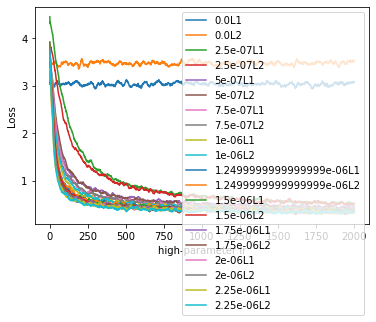

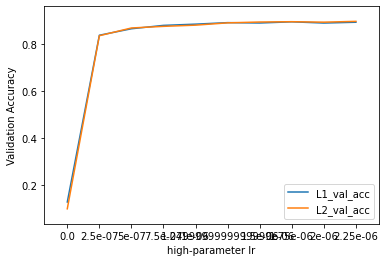

In [60]:
reg = 0.01
reg_types = ['L1', 'L2']
L1_loss = []
L2_loss = []
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
L1_lr_val_acc = []
L2_lr_val_acc = []

########################################
# TODO: train & test model with different learning rate
learning_rates = []
for i in range(10):
    learning_rates.append((2.5e-7)*i)

for i in range(10):
    model = LinearRegression2()
    loss_history = model.train(X_train, Y_train, learning_rates[i], reg, 'L1', True)
    pred = model.predict(X_val)
    acc = np.mean(pred == Y_val)
    L1_loss.append(loss_history)
    L1_lr_val_acc.append(acc)

for i in range(10):
    model = LinearRegression2()
    loss_history = model.train(X_train, Y_train, learning_rates[i], reg, 'L2', True)
    pred = model.predict(X_val)
    acc = np.mean(pred == Y_val)
    L2_loss.append(loss_history)
    L2_lr_val_acc.append(acc)

########################################

#visulize the relationship between lr and loss
for i, lr in enumerate(learning_rates):
    L1_loss_label = str(lr) + 'L1'
    L2_loss_label = str(lr) + 'L2'
    L1_loss_i = L1_loss[i]
    L2_loss_i = L2_loss[i]
    ave_L1_loss = np.zeros_like(L1_loss_i)
    ave_L2_loss = np.zeros_like(L2_loss_i)
    ave_step = 20
    for j in range(len(L1_loss_i)):
        if j < ave_step:
            ave_L1_loss[j] = np.mean(L1_loss_i[0: j + 1])
            ave_L2_loss[j] = np.mean(L2_loss_i[0: j + 1])
        else:
            ave_L1_loss[j] = np.mean(L1_loss_i[j - ave_step + 1: j + 1])    
            ave_L2_loss[j] = np.mean(L2_loss_i[j - ave_step + 1: j + 1])
    x = range(len(L1_loss_i))
    plt.plot(x, ave_L1_loss, label=L1_loss_label)
    plt.plot(x, ave_L2_loss, label=L2_loss_label)
    
plt.legend()
plt.xlabel('high-parameter lr')
plt.ylabel('Loss')
plt.show()

#visulize the relationship between lr and accuracy
x = range(len(learning_rates))
plt.plot(x, L1_lr_val_acc, label='L1_val_acc')
plt.plot(x, L2_lr_val_acc, label='L2_val_acc')
plt.xticks(x, learning_rates)
plt.margins(0.08)
plt.legend()
plt.xlabel('high-parameter lr')
plt.ylabel('Validation Accuracy')
plt.show()

### 2.5 正则项与模型性能
在这一部分中，你需要完成以下内容：
1. 尝试多个正则化参数的值
2. 储存对应的在**验证集上**的正确率到L1_reg_val_acc和L2_reg_val_acc中
3. 通过验证集X_val和Y_val选择最优的正则化超参数，并储存最优正则化参数和对应模型

已有的代码会画出正则化参数和验证集上正确率的关系图，并计算最优的模型在测试集上的正确率。

#### 注意：
和上面学习率一样，L1_reg_val_acc的存储也需要和正则化参数值对应。

train begin
In iteration 0/2000 , the loss is 3.362386067208112
In iteration 100/2000 , the loss is 0.47879053130899873
In iteration 200/2000 , the loss is 0.32053576249099575
In iteration 300/2000 , the loss is 0.27894179568259075
In iteration 400/2000 , the loss is 0.3994091501239838
In iteration 500/2000 , the loss is 0.187353469509917
In iteration 600/2000 , the loss is 0.27987661526183405
In iteration 700/2000 , the loss is 0.25905670242512485
In iteration 800/2000 , the loss is 0.20539774493575447
In iteration 900/2000 , the loss is 0.30700645573941104
In iteration 1000/2000 , the loss is 0.3493184601429523
In iteration 1100/2000 , the loss is 0.268923654813911
In iteration 1200/2000 , the loss is 0.22466426969494935
In iteration 1300/2000 , the loss is 0.20412963330250722
In iteration 1400/2000 , the loss is 0.336393615213686
In iteration 1500/2000 , the loss is 0.2094481052974819
In iteration 1600/2000 , the loss is 0.33452650150330615
In iteration 1700/2000 , the loss is 0.360

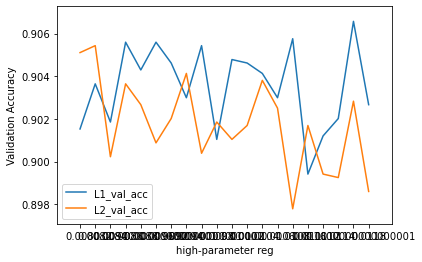

The Accuracy with L1 regularization parameter 0 is 0.9086

The Accuracy with L1 regularization parameter 0 is 0.9119



In [62]:
learning_rate = 1.5e-5 #initial 1.5e-6
reg_types = ['L1', 'L2']
L1_reg_val_acc = []
L2_reg_val_acc = []
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
best_L1_model = None
best_L2_model = None
best_L1_reg = 0
best_L2_reg = 0
best_L1_acc = 0
best_L2_acc = 0

########################################
# TODO: train & test model with different regularization 
best_L1_acc = 0
best_L2_acc = 0
regs = []
for i in range(20):
    regs.append(0.008+0.0002*i)

for i in range(20):
    model = LinearRegression2()
    loss_history = model.train(X_train, Y_train, learning_rate, regs[i], 'L1', True)
    pred = model.predict(X_val)
    acc = np.mean(pred == Y_val)
    L1_reg_val_acc.append(acc)
    if best_L1_acc < acc:
        best_L1_acc = acc
        best_L1_model = model
for i in range(20):
    model = LinearRegression2()
    loss_history = model.train(X_train, Y_train, learning_rate, regs[i], 'L2', True)
    pred = model.predict(X_val)
    acc = np.mean(pred == Y_val)
    L2_reg_val_acc.append(acc)
    if best_L2_acc < acc:
        best_L2_acc = acc
        best_L2_model = model

########################################

#visuliza the relation of regularization parameter and validation accuracy
x = range(len(regs))
plt.plot(x, L1_reg_val_acc, label='L1_val_acc')
plt.plot(x, L2_reg_val_acc, label='L2_val_acc')
plt.xticks(x, regs)
plt.margins(0.08)
plt.legend()
plt.xlabel('high-parameter reg')
plt.ylabel('Validation Accuracy')
plt.show()

#Compute the performance of best model on the test set
L1_pred = best_L1_model.predict(X_test)
L1_acc = np.mean(L1_pred == Y_test)
print("The Accuracy with L1 regularization parameter {} is {}\n".format(best_L1_reg, L1_acc))
L2_pred = best_L2_model.predict(X_test)
L2_acc = np.mean(L2_pred == Y_test)
print("The Accuracy with L1 regularization parameter {} is {}\n".format(best_L2_reg, L2_acc))

#### Question2: 对于上面的多分类逻辑回归模型，你觉得它的权重矩阵数值上会呈现出什么样子？你可以通过下面提供的可视化方法观察权重矩阵。

#### Answer:


In [63]:
lr_param = 1e-6
reg_param = 1000
model = LinearRegression2()
loss_history = model.train(X_train, Y_train, lr_param, reg_param, 'L2')
pred = model.predict(X_test)
acc = np.mean(pred == Y_test)
print("The Accuracy is {}\n".format(acc))

train begin
In iteration 0/2000 , the loss is 32.985261175242925
In iteration 100/2000 , the loss is 25.68667826645881
In iteration 200/2000 , the loss is 21.070720387587063
In iteration 300/2000 , the loss is 17.716113021266896
In iteration 400/2000 , the loss is 14.96559873334444
In iteration 500/2000 , the loss is 12.986409926529895
In iteration 600/2000 , the loss is 11.361920475992326
In iteration 700/2000 , the loss is 10.265065421823135
In iteration 800/2000 , the loss is 9.273168272213066
In iteration 900/2000 , the loss is 8.713606721258286
In iteration 1000/2000 , the loss is 8.290747099376283
In iteration 1100/2000 , the loss is 7.965229099888164
In iteration 1200/2000 , the loss is 7.743191370970703
In iteration 1300/2000 , the loss is 7.632915186332208
In iteration 1400/2000 , the loss is 7.499611979618976
In iteration 1500/2000 , the loss is 7.38400647825927
In iteration 1600/2000 , the loss is 7.543311066254348
In iteration 1700/2000 , the loss is 7.26671602661657
In ite

Weight matrix of digit  0


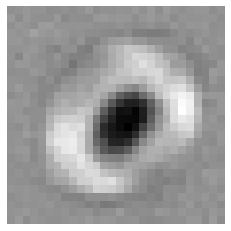

Weight matrix of digit  1


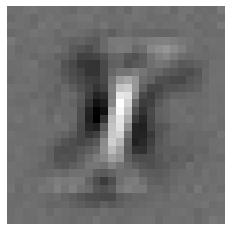

Weight matrix of digit  2


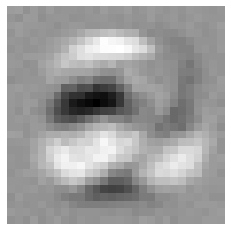

Weight matrix of digit  3


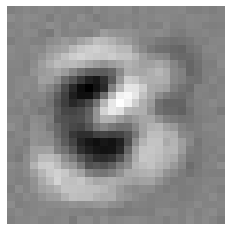

Weight matrix of digit  4


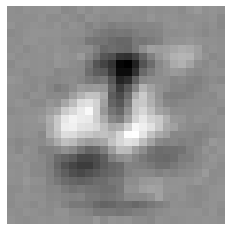

Weight matrix of digit  5


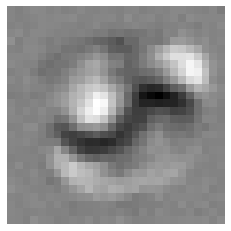

Weight matrix of digit  6


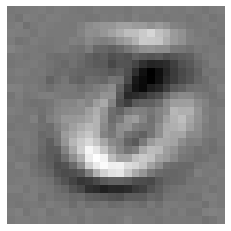

Weight matrix of digit  7


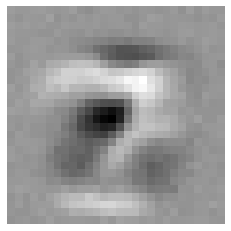

Weight matrix of digit  8


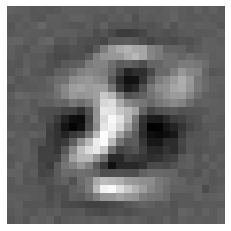

Weight matrix of digit  9


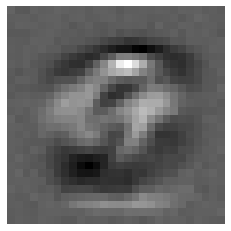

In [64]:
for i in range(10):
    pic = np.delete((model.W.T)[i], -1)
    pic = pic.reshape(28, -1)
    pic_min = np.min(pic)
    pic_max = np.max(pic)
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic)) * 255.0
    print("Weight matrix of digit ", i)
    plt.imshow(pic, cmap = plt.cm.gray)
    plt.axis('off')
    plt.show()